In [1]:
from src.utils import data_load
import pandas as pd
from src.s3_utils import pandas_from_csv_s3
import numpy as np

In [2]:
data = data_load(data_keys={'bodyport', 'oura_activity', 'oura_sleep', "surveys"})



In [3]:
data['bodyport']['subsource'].unique()
# subsource is only `weight`

array(['weight'], dtype=object)

In [4]:
data_bodyport = data['bodyport']
users = data_bodyport['user_id'].unique().tolist()
most_data_user = -1
most_data = -1
for u in users:
    num_data = len(data_bodyport[data_bodyport['user_id'] == u])
    if num_data > most_data:
        most_data = num_data
        most_data_user = u
most_data_user
# userid 74 has the most data

74

In [100]:
selected_user = 1441
selected_data_bodyport = data_bodyport[data_bodyport['user_id'] == selected_user][['date', 'impedance_ratio', 'peripheral_fluid', 'impedance_mag_1_ohms', 'impedance_phase_1_degs', 'weight_kg']].groupby("date", as_index = False).mean()


In [101]:
data_oura_activity = data['oura_activity']
data_oura_activity[data_oura_activity['user_id'] == selected_user]
data_oura_sleep = data['oura_sleep']

In [122]:
def na_rate(df):
    return np.max(np.sum(df.isna()))/len(df)
na_rate(data_oura_activity)
np.sum(data_oura_activity.isna())

46927

In [102]:
selected_data_oura_activity = data_oura_activity[data_oura_activity['user_id'] == selected_user][[
 'cal_active',
 'cal_total',
 'daily_movement',
 'high',
 'inactive',
#  'inactivity_alerts',
 'low',
 'medium',
 'met_min_high',
 'met_min_inactive',
 'met_min_low',
 'met_min_medium',
 'non_wear',
 'rest',
#  'rest_mode_state',
#  'score',
#  'score_meet_daily_targets',
#  'score_move_every_hour',
#  'score_recovery_time',
#  'score_stay_active',
#  'score_training_frequency',
#  'score_training_volume',
 'steps',
 'date']]

In [103]:
def get_min_date(df):
    return np.min(df['date'])
def get_max_date(df):
    return np.max(df['date'])

In [104]:

# # union
# overall_min_date = np.min([get_min_date(selected_data_bodyport), get_min_date(selected_data_oura_activity)])
# overall_max_date = np.max([get_max_date(selected_data_bodyport), get_max_date(selected_data_oura_activity)])

# intercept
overall_min_date = np.max([get_min_date(selected_data_bodyport), get_min_date(selected_data_oura_activity)])
overall_max_date = np.min([get_max_date(selected_data_bodyport), get_max_date(selected_data_oura_activity)])

date_range = pd.date_range(overall_min_date, overall_max_date, freq='d')
date_df = pd.DataFrame()
date_df['date'] = date_range
selected_data_bodyport['date'] = selected_data_bodyport['date'].astype('datetime64')
selected_data_oura_activity['date'] = selected_data_oura_activity['date'].astype('datetime64')
selected_data_bodyport = pd.merge(date_df, selected_data_bodyport, how='left')
selected_data_oura_activity = pd.merge(date_df, selected_data_oura_activity, how='left')

unimputed_df = pd.DataFrame()
unimputed_df['date'] = date_range
unimputed_df = pd.merge(unimputed_df, selected_data_bodyport, how='left')
unimputed_df = pd.merge(unimputed_df, selected_data_oura_activity, how='left')
np.sum(unimputed_df.isna())
date_range

DatetimeIndex(['2021-12-19', '2021-12-20', '2021-12-21', '2021-12-22',
               '2021-12-23', '2021-12-24', '2021-12-25', '2021-12-26',
               '2021-12-27', '2021-12-28',
               ...
               '2022-06-03', '2022-06-04', '2022-06-05', '2022-06-06',
               '2022-06-07', '2022-06-08', '2022-06-09', '2022-06-10',
               '2022-06-11', '2022-06-12'],
              dtype='datetime64[ns]', length=176, freq='D')

In [105]:
# fill missing days with randomly selected days from previous 14 days window
np.random.seed(90)
activity_mask = selected_data_oura_activity.drop('date', axis=1).isna().all(1)
bodyport_mask = selected_data_bodyport.drop('date', axis=1).isna().all(1)
def random_fill_missing_day(df, mask, window=30):
    if 'date' in df.columns.to_list(): 
        df = df.drop('date', axis=1)
    for i in range(len(mask)):
        if mask[i]:
            if i < window: # do random filling
                available_indice = np.where(mask == False)[0]
                random_observation = df.iloc[np.random.choice(available_indice)]
            else:
                random_index = np.random.randint(low=1, high=window)

                random_observation = df.iloc[i-random_index]
                # print(':',i-random_index)
                # print(i)
                # print(random_index)

            df.iloc[i] = random_observation

    return df
random_filled_oura_activity = random_fill_missing_day(selected_data_oura_activity.drop('date', axis=1), activity_mask)
#np.sum(out.isna().all(1))
random_filled_bodyport = random_fill_missing_day(selected_data_bodyport.drop('date', axis=1), bodyport_mask)
random_filled_oura_activity['date'] = date_range
random_filled_bodyport['date'] = date_range

overall_df = pd.merge(random_filled_oura_activity, random_filled_bodyport, how='left')



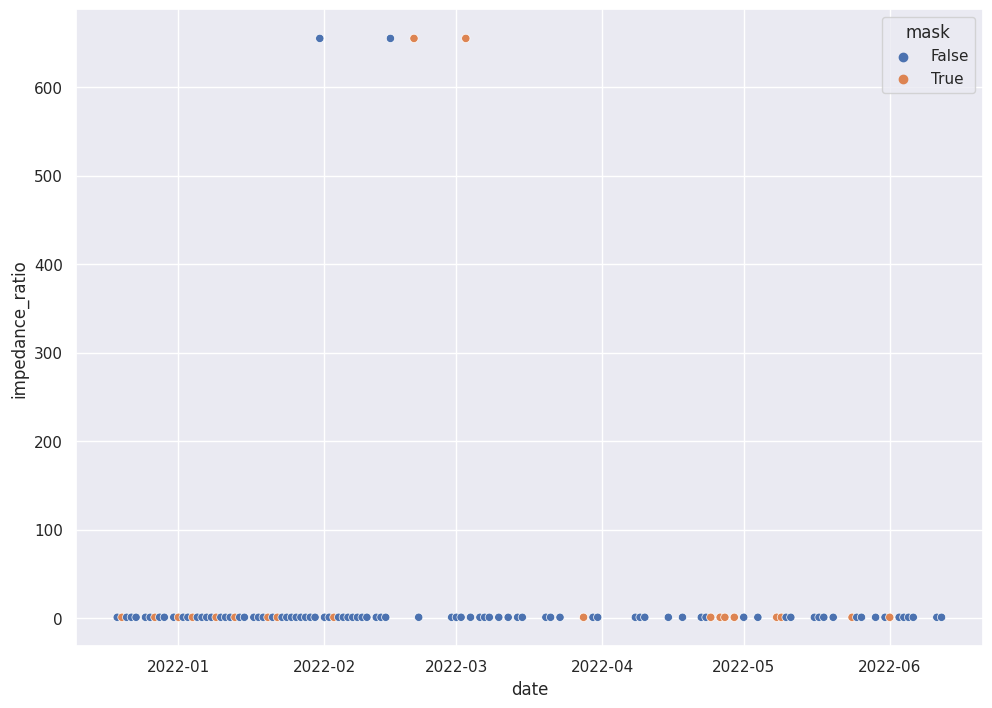

In [106]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style='darkgrid')
sns.set(rc={'figure.figsize':(11.7,8.27)})
# sns.scatterplot(x=overall_df["date"], y=overall_df["non_wear"], hue=unimputed_df['non_wear'].isna())
overall_df['mask'] = unimputed_df['impedance_ratio'].isna()
graph = sns.scatterplot(data=overall_df, x="date", y="impedance_ratio", hue="mask")

# df_birth = data_load(data_keys={'birth'})['birth']
# df_birth[df_birth.user_id == selected_user].birth_date.values[0]
# graph.axvline(pd.to_datetime(df_birth[df_birth.user_id == selected_user].birth_date.values[0]))

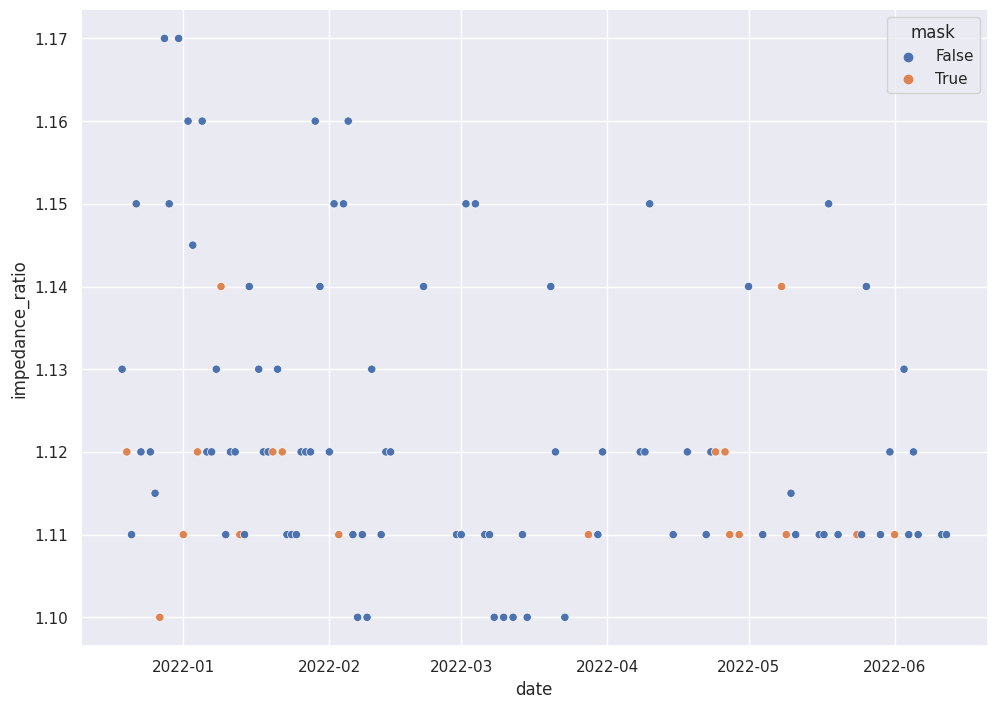

In [107]:
overall_df.loc[overall_df['impedance_ratio'] > 10,'impedance_ratio'] = np.nan
graph = sns.scatterplot(data=overall_df, x="date", y="impedance_ratio", hue="mask")

# df_birth = data_load(data_keys={'birth'})['birth']
# df_birth[df_birth.user_id == selected_user].birth_date.values[0]
# graph.axvline(pd.to_datetime(df_birth[df_birth.user_id == selected_user].birth_date.values[0]))

In [108]:
np.sum(overall_df.isna())

cal_active                 0
cal_total                  0
daily_movement             0
high                       0
inactive                   0
low                        0
medium                     0
met_min_high               0
met_min_inactive           0
met_min_low                0
met_min_medium             0
non_wear                   0
rest                       0
steps                      0
date                       0
impedance_ratio           72
peripheral_fluid          61
impedance_mag_1_ohms      70
impedance_phase_1_degs    70
weight_kg                  0
mask                       0
dtype: int64

In [109]:
overall_df.describe()

,cal_active,cal_total,daily_movement,high,inactive,low,medium,met_min_high,met_min_inactive,met_min_low,met_min_medium,non_wear,rest,steps,impedance_ratio,peripheral_fluid,impedance_mag_1_ohms,impedance_phase_1_degs,weight_kg
count,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,104.000000,115.000000,106.000000,106.000000,176.000000
mean,557.261364,2718.585227,9896.357955,0.920455,406.278409,426.340909,48.670455,6.545455,13.556818,273.153409,164.363636,74.312500,463.806818,10994.375000,1.121971,1.508935,614.169811,-5.125000,58.376023
std,204.631068,268.899840,3893.532410,1.691806,107.830644,127.037712,28.747858,11.923958,4.032321,88.373198,99.355142,143.527316,145.590687,3676.449577,0.016944,0.476883,60.686269,0.789462,1.838846
min,66.000000,1965.000000,1231.000000,0.000000,32.000000,42.000000,5.000000,0.000000,1.000000,32.000000,21.000000,0.000000,49.000000,1202.000000,1.100000,0.000000,417.000000,-12.000000,55.100000
25%,410.250000,2511.000000,7245.000000,0.000000,347.000000,355.750000,28.000000,0.000000,11.000000,218.500000,94.000000,0.000000,374.250000,8530.500000,1.110000,1.495000,562.000000,-5.300000,56.607500
50%,541.000000,2712.000000,9494.500000,0.000000,399.000000,423.000000,44.000000,0.000000,14.000000,272.000000,146.000000,22.000000,487.000000,10773.500000,1.120000,1.610000,618.000000,-4.900000,58.585000
75%,703.500000,2932.750000,12640.500000,1.000000,487.000000,526.000000,59.500000,7.000000,16.000000,345.000000,202.500000,63.000000,577.500000,13806.250000,1.130000,1.770000,652.250000,-4.800000,59.900000
max,1259.000000,3496.000000,22881.000000,13.000000,707.000000,772.000000,183.000000,89.000000,24.000000,562.000000,677.000000,1026.000000,960.000000,20161.000000,1.170000,2.400000,758.000000,-4.300000,62.460000


In [110]:
# hyperimpute requires python 3.7
from hyperimpute.plugins.imputers import Imputers
import numpy as np
import pandas as pd
import hyperimpute as hp

imputers = Imputers()

imputers.list()
method = 'hyperimpute'
plugin = Imputers().get(method)

# X = pd.DataFrame([[1, 1, 1, 1], [4, 5, np.nan, 4], [3, 3, 9, 9], [2, 2, 2, 2]])

# print(np.sum(X.isna()))
# out = plugin.fit_transform(X)

X = overall_df.drop('date', axis=1).drop('mask', axis=1)
print(np.sum(X.isna()))
print(X.shape)
out = plugin.fit_transform(X.copy())

# print(method, out)

cal_active                 0
cal_total                  0
daily_movement             0
high                       0
inactive                   0
low                        0
medium                     0
met_min_high               0
met_min_inactive           0
met_min_low                0
met_min_medium             0
non_wear                   0
rest                       0
steps                      0
impedance_ratio           72
peripheral_fluid          61
impedance_mag_1_ohms      70
impedance_phase_1_degs    70
weight_kg                  0
dtype: int64
(176, 19)


In [111]:
hyperimputed_df_without_date = out
hyperimputed_df_without_date.to_csv(f'/mnt/results/user_{selected_user}_activity_bodyport_hyperimpute.csv', index=False, header=False)

In [112]:
hyperimputed_df_with_date = hyperimputed_df_without_date.copy()
hyperimputed_df_with_date['date'] = date_range
hyperimputed_df_with_date.to_csv(f'/mnt/results/user_{selected_user}_activity_bodyport_hyperimpute_with_date.csv', index=False)

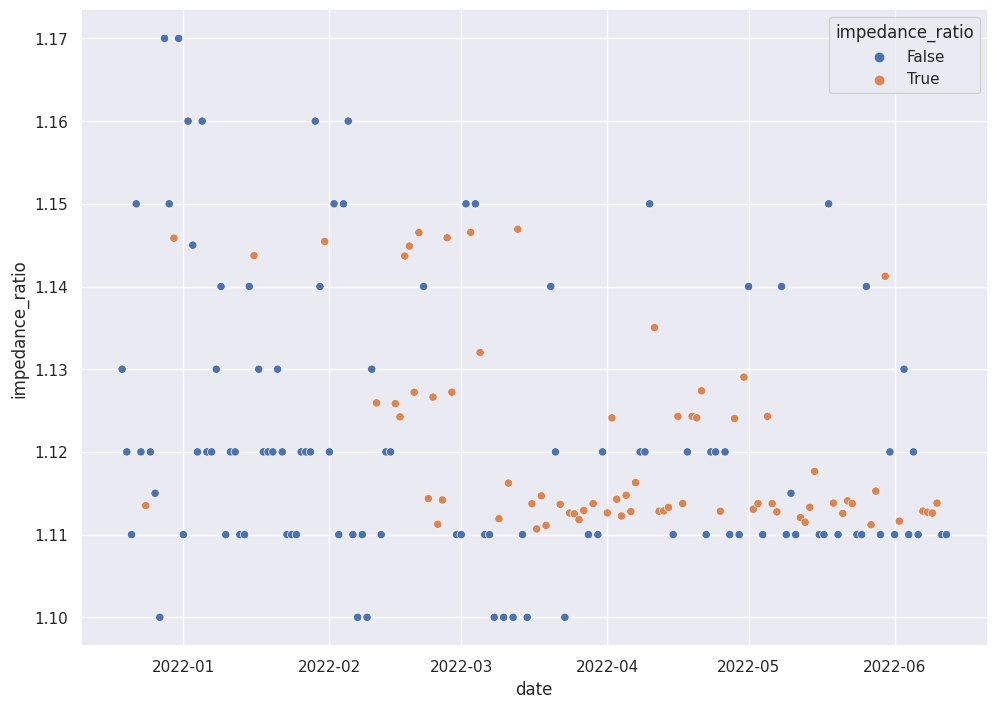

In [113]:
g2 = sns.scatterplot(x=hyperimputed_df_with_date["date"], y=hyperimputed_df_without_date["impedance_ratio"], hue=overall_df['impedance_ratio'].isna())
# g2.axvline(pd.to_datetime(df_birth[df_birth.user_id == selected_user].birth_date.values[0]))

In [114]:
overall_df_without_date = overall_df.drop('date', axis=1)
overall_df_without_date.to_csv(f'/mnt/results/user_{selected_user}_activity_bodyport_rand_filled.csv', index=False, header=False)

In [115]:
# handle survey
df_survey = data['surveys']
df_puqe = data['surveys'].loc[data['surveys']['title']=='PUQE']
selected_user_puqe = df_puqe[df_puqe['user_id'] == selected_user]

In [116]:

answer_dict = {
    'No': 1,
    'Yes': 2,
    'Not at all': 1,
    '1 hour or less': 2,
    '2 to 3 hours':3, 
    '4 to 6 hours':4, 
    '6 or more hours':5,
    '1-2 times': 2,
    '3-4 times': 3,
    '5-6 times': 4,
    '7 or more times': 5
}

answer_catagory = {
    (0, 6) : 0,
    (7, 12): 1,
    (13, 21): 2
}
def map_levels(x, map_dict):
    for key in map_dict:
        if isinstance(x, str):
            if x == key:
                return map_dict[key]
        else:
            if x >= key[0] and x <= key[1]:
                return map_dict[key]
# 53, 54, 132, 404
# 404: 'During the past week, did you experience any nausea?'
# 132: 'On average in a day, for how long do you feel nauseated or sick to your stomach?'
# 53: 'On average in a day, how many times do you vomit or throw up?'
# 54: 'On average in a day, how many times have you had retching or dry heaves without bringing anything up?'

# for qid in selected_user_puqe['question_id'].unique():
#     question_df = selected_user_puqe.loc[selected_user_puqe['question_id'] == qid]
#     question_df['answer_text'] = question_df['answer_text'].astype(object)
#     print(question_df['answer_text'])
#     if qid == 404:
#         question_df.replace({"answer_text": answer_dict1}, inplace=True)
#     elif qid == 132:
#         question_df.replace({"answer_text": answer_dict2}, inplace=True)
#     else:
#         question_df.replace({"answer_text": answer_dict3}, inplace=True)
selected_user_puqe['answer_text'] = selected_user_puqe['answer_text'].astype(object)
selected_user_puqe.replace({"answer_text": answer_dict}, inplace=True)
aggregated_user_puqe = selected_user_puqe.groupby('date', as_index=False).sum()
for k in answer_catagory:
    aggregated_user_puqe['answer_text'] = np.where(aggregated_user_puqe['answer_text'].between(k[0],k[1]), answer_catagory[k], aggregated_user_puqe['answer_text'])

aggregated_user_puqe.to_csv(f'/mnt/results/user_{selected_user}_puqe.csv', index=False, header=True)

In [117]:
df = pd.read_csv(f'/mnt/results/user_{selected_user}_puqe.csv')

In [118]:
df

,date,id,user_id,survey_id,question_id,answer_text
0,2021-12-19,2710772,5764,8,643,1
1,2021-12-25,2818036,5764,8,643,1
2,2022-01-01,2944000,5764,8,643,1
3,2022-01-09,3067620,5764,8,643,1
4,2022-01-16,3195212,5764,8,643,1
5,2022-01-22,3328964,5764,8,643,1
6,2022-01-29,3465184,5764,8,643,1
7,2022-02-05,3600288,5764,8,643,1
8,2022-02-12,3736760,5764,8,643,1
9,2022-02-19,3872576,5764,8,643,1
